# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import random
import math
from scipy import stats
import scikit_posthocs as sp

# TDA
import kmapper as km
import dyneusr as dsr
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from kmapper.cover import Cover
from tmap.tda.utils import optimize_dbscan_eps

In [2]:
# Set seed for reproducibility
seed_value = 100
random.seed(seed_value)

# **2. Import data**

In [3]:
data_path = '/Users/stefanovannoni/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Dottorato/Tesi Magistrale/sMRI_data.csv'

# Load data
data = pd.read_csv(data_path)

# Remove class labels
x = data.drop('study_group', axis=1)

# Class labels
y = data['study_group']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(int)

In [4]:
# Print data shape
print("Data shape: ", x.shape)

Data shape:  (587, 68)


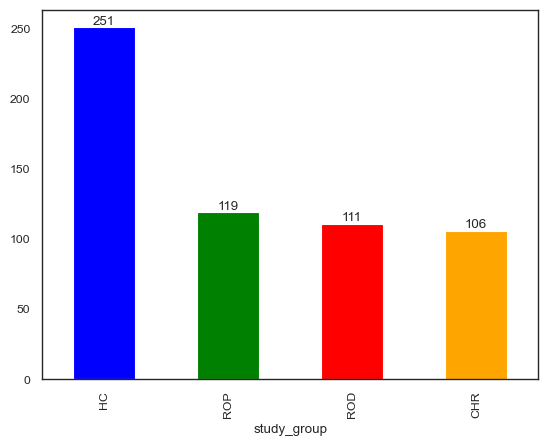

In [5]:
# Class labels histogram
labels_freq = data['study_group'].value_counts()
colors_ = ['blue', 'green', 'red', 'orange']
labels_freq.plot(kind='bar', color=colors_)

for i, valore in enumerate(labels_freq):
    plt.text(i, valore, str(valore), ha='center', va='bottom')

plt.show()

In [6]:
# Only HC samples
x_hc = data[data['study_group'] == 'HC']
x_hc = x_hc.drop('study_group', axis=1)

In [7]:
# HC class labels
y_hc = data[data['study_group'] == 'HC']
y_hc = y_hc['study_group']
y_hc_dummy = pd.get_dummies(y_hc)
y_hc_dummy = y_hc_dummy.astype(int)

In [8]:
# Patient samples
x_rop = data[data['study_group'] == 'ROP']
x_rop = x_rop.drop('study_group', axis=1)

x_rod = data[data['study_group'] == 'ROD']
x_rod = x_rod.drop('study_group', axis=1)

x_chr = data[data['study_group'] == 'CHR']
x_chr = x_chr.drop('study_group', axis=1)

# **3. Project data (Filtering)**

In [9]:
# PCA
kernelpca = KernelPCA(n_components=2, kernel='rbf', random_state=seed_value)
kernelpca = kernelpca.fit(x_hc)

In [10]:
# Projection into 2D
x_hc_kernelpca = kernelpca.transform(x_hc)

# **4. TDA**

In [11]:
mapper = km.KeplerMapper(verbose=0)

In [12]:
# Create lens function
lens_kernelpca = mapper.fit_transform(kernelpca.fit_transform(x_hc), projection=[0, 1], scaler=None)

# **5. Framework application**

In [13]:
def mapping_tda(data, sample, cover):
    # Add index column to data
    idx = np.arange(data.shape[0])[:, np.newaxis]
    data = np.hstack((idx, data))

    # Fit cover and get cube centers
    bins = cover.fit(data)
    bins = [(sublist[0], sublist[1]) for sublist in bins]

    # Transform data into hypercubes
    hypercubes = cover.transform(data, bins)

    # Find indices of cubes containing the sample
    index_cubes = cover.find(sample)

    # Get indices of matching hypercubes
    hypercubes_index = []
    for index in index_cubes:
        cube = cover.transform_single(data, bins[index])

        for j in range(len(hypercubes)):
            if np.array_equal(cube, hypercubes[j]):
                hypercubes_index.append(j)

    # # Print hypercubes with only one sample
    # for k in hypercubes_index:
    #     if len(hypercubes[k]) == 1:
    #         print(f'Hyper cube {k} with only one sample')
    #     else:
    #         continue

    # Return indices, hypercubes, and centers
    return hypercubes_index, hypercubes, bins

In [14]:
def get_barycenter(hypercubes):
    hypercubes_coordinates = {}
    for i, cube in enumerate(hypercubes):
        points = cube[:, 1:]
        points_center = np.mean(points, axis=0)
        hypercubes_coordinates[i] = [points_center, len(points)]

    sum_x = 0
    sum_y = 0
    total_points = 0

    # Compute weighted barycenter
    for point in hypercubes_coordinates.values():
        coordinates, weight = point
        x, y = coordinates
        sum_x += x * weight
        sum_y += y * weight
        total_points += weight

    barycenter = [sum_x / total_points, sum_y / total_points]

    return barycenter

In [15]:
# Define Cover parameters ranges
res_range = [0.52, 0.54, 0.56, 0.58, 0.60, 0.62, 0.64, 0.66, 0.68]
gain_range = [20, 25, 30, 35, 40, 45, 50, 55, 60]

n_res = len(res_range)
n_gain = len(gain_range)

n_iteration = n_res * n_gain
print(f'Number of iterations: {n_iteration}')

Number of iterations: 81


## **5.1. Grid Search**

In [ ]:
kernelpca_results = {}

for i, res in enumerate(res_range):
    for j, gain in enumerate(gain_range):
        print(f'Cover parameters: {res}, {gain}, iteration: {i+1} out of {len(res_range)}')
        if j == 8:
            print('==========================')

        # TDA GRAPH CREATION
        cover = Cover(n_cubes=gain, perc_overlap=res)
        graph = mapper.map(
            lens=lens_kernelpca,
            X=x_hc,
            cover=cover,
            clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
        )
        graph_nx = km.adapter.to_nx(graph)
        nodes_index = [int(element.split('cube')[1].split('_')[0]) for element in list(graph_nx.nodes())]
        n_nodes = len(nodes_index)

        #################################################################################################################################################

        # BARYCENTER
        idx = np.arange(x_hc_kernelpca.shape[0])[:, np.newaxis]
        new_data = np.hstack((idx, x_hc_kernelpca))
        bins = cover.fit(new_data)
        bins = [(sublist[0], sublist[1]) for sublist in bins]
        hypercubes = cover.transform(new_data, bins)
        hypercubes_ = [cube for i, cube in enumerate(hypercubes) if i in nodes_index] # Get nodes hypercubes
        barycenter = get_barycenter(hypercubes_)

        # NODES DISTANCE FROM BARYCENTER
        hc_distance = []
        for cube in hypercubes_:
            center = np.mean(cube[:, 1:], axis=0)
            hc_distance.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

        #################################################################################################################################################
                    
        # PATIENT SAMPLES PROJECTION
            
        # ROP
        rop_distance = []
        rop_distance_not_mapped = []
        for k in range(len(x_rop)):
            patient = x_rop.iloc[[k]]
            patient_kernelpca = kernelpca.transform(patient)

            # Mapping
            hypercubes_index_rop, hypercubes_rop, bins_rop = mapping_tda(x_hc_kernelpca, patient_kernelpca, cover)

            if len(hypercubes_index_rop) > 0:
                rop_dist = []
                for index in hypercubes_index_rop:
                    if index in nodes_index:
                        cube = hypercubes_rop[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_kernelpca), axis=0), axis=0)
                        rop_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rop_distance.append(np.mean(np.array(rop_dist)))
            else:
                rop_distance_not_mapped.append(math.sqrt((patient_kernelpca[0][0] - barycenter[0]) ** 2 + (patient_kernelpca[0][1] - barycenter[1]) ** 2))

        rop_noisy = len([value for value in rop_distance if math.isnan(value)])
        rop_distance = [value for value in rop_distance if not math.isnan(value)]
        rop_not_mapped = len(rop_distance_not_mapped)

        #############################################

        # ROD
        rod_distance = []
        rod_distance_not_mapped = []
        for k in range(len(x_rod)):
            patient = x_rod.iloc[[k]]
            patient_kernelpca = kernelpca.transform(patient)

            # Mapping
            hypercubes_index_rod, hypercubes_rod, bins_rod = mapping_tda(x_hc_kernelpca, patient_kernelpca, cover)

            if len(hypercubes_index_rod) > 0:
                rod_dist = []
                for index in hypercubes_index_rod:
                    if index in nodes_index:
                        cube = hypercubes_rod[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_kernelpca), axis=0), axis=0)
                        rod_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rod_distance.append(np.mean(np.array(rod_dist)))
            else:
                rod_distance_not_mapped.append(math.sqrt((patient_kernelpca[0][0] - barycenter[0]) ** 2 + (patient_kernelpca[0][1] - barycenter[1]) ** 2))

        rod_noisy = len([value for value in rod_distance if math.isnan(value)])
        rod_distance = [value for value in rod_distance if not math.isnan(value)]
        rod_not_mapped = len(rod_distance_not_mapped)

        #############################################

        # CHR
        chr_distance = []
        chr_distance_not_mapped = []
        for k in range(len(x_chr)):
            patient = x_chr.iloc[[k]]
            patient_kernelpca = kernelpca.transform(patient)

            # Mapping
            hypercubes_index_chr, hypercubes_chr, bins_chr = mapping_tda(x_hc_kernelpca, patient_kernelpca, cover)
            
            if len(hypercubes_index_chr) > 0:
                chr_dist = []
                for index in hypercubes_index_chr:
                    if index in nodes_index:
                        cube = hypercubes_chr[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_kernelpca), axis=0), axis=0)
                        chr_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                chr_distance.append(np.mean(np.array(chr_dist)))
            else:
                chr_distance_not_mapped.append(math.sqrt((patient_kernelpca[0][0] - barycenter[0]) ** 2 + (patient_kernelpca[0][1] - barycenter[1]) ** 2))

        chr_noisy = len([value for value in chr_distance if math.isnan(value)])
        chr_distance = [value for value in chr_distance if not math.isnan(value)]
        chr_not_mapped = len(chr_distance_not_mapped)

        #################################################################################################################################################

        # RESULTS
        kernelpca_results[tuple((res, gain))] = [hc_distance, n_nodes, rop_distance, rop_distance_not_mapped, rop_not_mapped, rop_noisy, rod_distance, rod_distance_not_mapped, rod_not_mapped, rod_noisy, chr_distance, chr_distance_not_mapped, chr_not_mapped, chr_noisy]

## **5.2. Print results**

In [17]:
kernelpca_results_df = pd.DataFrame.from_dict(kernelpca_results, orient='index', columns=['Reference distance (HC)', 'N. nodes', 'ROP distance', 'ROP not mapped distnace', 'N. ROP not mapped', 'N. Noisy ROP', 'ROD distance', 'ROD not mapped distnace', 'N. ROD not mapped', 'N. Noisy ROD', 'CHR distance', 'CHR not mapped distance', 'N. CHR not mapped', 'N. Noisy CHR'])

In [18]:
kernelpca_results_df

,Reference distance (HC),N. nodes,ROP distance,ROP not mapped distnace,N. ROP not mapped,N. Noisy ROP,ROD distance,ROD not mapped distnace,N. ROD not mapped,N. Noisy ROD,CHR distance,CHR not mapped distance,N. CHR not mapped,N. Noisy CHR
"(0.52, 20)","[0.5029098282733077, 0.4175987598307189, 0.417...",155,"[0.26784050029913686, 0.11278407665083813, 0.2...",[0.39126162609249476],1,11,"[0.06414241607445383, 0.21410459988874098, 0.3...",[0.4315475739795494],1,9,"[0.037420273283183335, 0.15218224725980622, 0....",[0.4319421786777442],1,14
"(0.52, 25)","[0.519815676314219, 0.4280811070304936, 0.3566...",134,"[0.2652487955982574, 0.2673274361895919, 0.229...","[0.41840175494707366, 0.33267928899317806]",2,24,"[0.053496584972403005, 0.19207470600798893, 0....",[0.42877563411455355],1,32,"[0.0510648422647349, 0.12632671362773218, 0.26...","[0.457560767694176, 0.2620716090564052]",2,34
"(0.52, 30)","[0.49541509458160876, 0.40204482285039383, 0.3...",129,"[0.2914853423604413, 0.40231466725990944, 0.41...","[0.42394842747132827, 0.23373726904352454, 0.3...",5,45,"[0.21658081777363156, 0.39716586199661685, 0.1...","[0.4546536419074614, 0.22766103670044682, 0.25...",3,43,"[0.053487051024785195, 0.1447361587367572, 0.2...","[0.4046093700938748, 0.4656746787672595, 0.190...",5,45
"(0.52, 35)","[0.4565312091820207, 0.37711877074638855, 0.33...",96,"[0.26775100508818067, 0.24082657307630234, 0.3...","[0.316350759801237, 0.4156181421368414, 0.2699...",6,58,"[0.16815273029635278, 0.1559938163601928, 0.01...","[0.40108172613108517, 0.15507449487715025, 0.2...",7,60,"[0.3860942876582748, 0.2125983442579886, 0.180...","[0.45947653421728224, 0.4517337553519897, 0.29...",9,62
"(0.52, 40)","[0.32252710628806824, 0.30887238418188523, 0.2...",89,"[0.37198058909146503, 0.3919759689624656, 0.28...","[0.24028036340635023, 0.18656798148074322, 0.3...",11,68,"[0.04918569449429698, 0.3609496488421893, 0.16...","[0.4112442172222844, 0.1536752007579029, 0.249...",8,66,"[0.08350070504091818, 0.134070482787447, 0.290...","[0.20506454224992648, 0.30562867979462477, 0.2...",16,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(0.68, 40)","[0.5066979908243472, 0.5066979908243472, 0.506...",293,"[0.2733265439140024, 0.2926928291230773, 0.237...","[0.40844678029183357, 0.23446669014145113, 0.3...",3,24,"[0.04301622111085099, 0.20967585570921635, 0.3...","[0.43599058075813407, 0.25658176889907547]",2,24,"[0.045212597742773496, 0.14087788192763787, 0....","[0.44886656225211896, 0.24962808243233997]",2,28
"(0.68, 45)","[0.5134099979852362, 0.5134099979852362, 0.513...",260,"[0.27257624283735243, 0.2668231596945547, 0.37...","[0.4057614792934652, 0.23853019127449135, 0.32...",5,35,"[0.04067171666164947, 0.20138629753335474, 0.3...","[0.42829421377255655, 0.22788207487002607, 0.2...",3,27,"[0.05659827158890139, 0.15310308618474452, 0.2...","[0.4454380687339458, 0.2500270315367235, 0.254...",3,39
"(0.68, 50)","[0.5326581171635995, 0.5326581171635995, 0.440...",230,"[0.27449812077920854, 0.2545056294887302, 0.37...","[0.33308909813638515, 0.42078012338262083, 0.2...",6,40,"[0.1778835849939608, 0.37538146565543784, 0.16...","[0.41782424491884024, 0.25022869787505203, 0.2...",3,44,"[0.08023169670412066, 0.1296852708196507, 0.28...","[0.4585961632097994, 0.2724253653229109, 0.276...",3,55
"(0.68, 55)","[0.5276005109096293, 0.5276005109096293, 0.437...",219,"[0.2748379445685492, 0.37179938975631627, 0.39...","[0.24840438897409994, 0.4140106911029519, 0.25...",6,59,"[0.05443220535231961, 0.1877550585596169, 0.36...","[0.418974981490685, 0.15274266509836565, 0.242...",4,51,"[0.1366365087234015, 0.28185084640920144, 0.36...","[0.4403250424655363, 0.45226184269966563, 0.29...",8,54


In [27]:
# Save results
kernelpca_results_df.to_csv('kernelpca_rbf_results.csv')

# **6. Statistical Analysis**

In [19]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [20]:
# Resolution and Gain ranges
res_ = [str(value) for value in res_range]
gain_ = [str(value) for value in gain_range]

## **6.1. Kruskal-Wallis test**

- HC vs others

In [21]:
kernelpca_results_matrix_kruskal_1 = np.zeros((n_res, n_gain))
significant_results_1 = {}

for i, res in enumerate(res_range):
    for j, gain in enumerate(gain_range):
        h_stat, p_value = stats.kruskal(kernelpca_results[(res, gain)][0], np.concatenate((
            kernelpca_results[(res, gain)][2], 
            kernelpca_results[(res, gain)][6], 
            kernelpca_results[(res, gain)][10])), axis=0)
        kernelpca_results_matrix_kruskal_1[i, j] = p_value

        if p_value < 0.05:
            significant_results_1[(res, gain)] = kernelpca_results[(res, gain)]

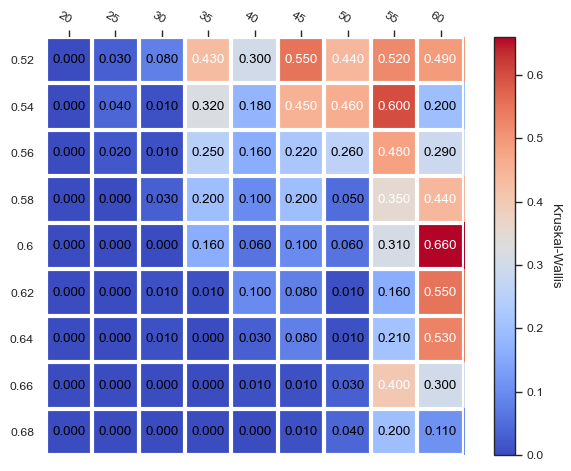

In [22]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(kernelpca_results_matrix_kruskal_1, decimals=2, out=None), res_, gain_, ax=ax,
                   cmap="coolwarm", cbarlabel="Kruskal-Wallis")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

- HC vs ROP vs ROD vs CHR

In [23]:
kernelpca_results_matrix_kruskal_2 = np.zeros((n_res, n_gain))
significant_results_2 = {}

for i, res in enumerate(res_range):
    for j, gain in enumerate(gain_range):
        h_stat, p_value = stats.kruskal(
            kernelpca_results[(res, gain)][0], 
            kernelpca_results[(res, gain)][2], 
            kernelpca_results[(res, gain)][6], 
            kernelpca_results[(res, gain)][10])
        kernelpca_results_matrix_kruskal_2[i, j] = p_value

        if p_value < 0.05:
            significant_results_2[(res, gain)] = kernelpca_results[(res, gain)]

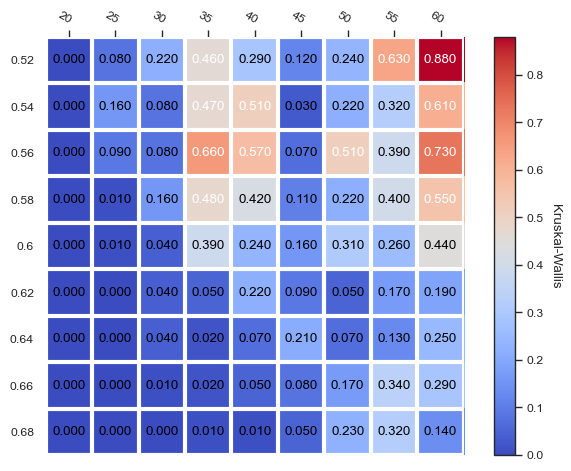

In [24]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(kernelpca_results_matrix_kruskal_2, decimals=2, out=None), res_, gain_, ax=ax,
                   cmap="coolwarm", cbarlabel="Kruskal-Wallis")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

## **6.2. Post-Hoc analysis**

In [25]:
post_hoc_results = {}
for key, value in significant_results_2.items():
    post_hoc_results[key] = sp.posthoc_dunn([value[0], value[2], value[6], value[10]])

In [26]:
for key, value in post_hoc_results.items():
    print(f'Cover parameters: {key}')
    print(value)
    print('==========================')

Cover parameters: (0.52, 20)
          1         2         3         4
1  1.000000  0.000185  0.001314  0.026039
2  0.000185  1.000000  0.662859  0.206726
3  0.001314  0.662859  1.000000  0.408092
4  0.026039  0.206726  0.408092  1.000000
Cover parameters: (0.54, 20)
          1         2         3         4
1  1.000000  0.000192  0.000983  0.032856
2  0.000192  1.000000  0.729117  0.188174
3  0.000983  0.729117  1.000000  0.333507
4  0.032856  0.188174  0.333507  1.000000
Cover parameters: (0.54, 45)
          1         2         3         4
1  1.000000  0.222957  0.088503  0.090452
2  0.222957  1.000000  0.617589  0.014850
3  0.088503  0.617589  1.000000  0.005448
4  0.090452  0.014850  0.005448  1.000000
Cover parameters: (0.56, 20)
          1         2         3         4
1  1.000000  0.000213  0.000497  0.027686
2  0.000213  1.000000  0.891176  0.223587
3  0.000497  0.891176  1.000000  0.285750
4  0.027686  0.223587  0.285750  1.000000
Cover parameters: (0.58, 20)
          1    